# Dependencies

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import math
from PIL import Image, ImageFilter
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import MaxPooling2D, Flatten, Dense, Input

In [2]:
#Run the process on CPU

os.environ['CUDA_VISIBLE_DEVICES'] = ''

#### Auxillary Functions

In [3]:
def normalize(image):
    image /= 255.0
    image = np.round(image, 4)
    return image


def display_image(image_count, images, index, columns, fig_size):
    # Find the number of rows and columns required
    rows = max(math.ceil(image_count / columns), 1)
    cols = min(image_count, columns)
    if image_count % cols == 0:
        rows += 1
    fig, axes = plt.subplots(rows, cols, figsize=fig_size)

    # Iterate over each row and column in the figure and display an image
    for i in range(rows):
        for j in range(cols):

            # If this is the last row and there are empty columns, remove the axis
            if i == rows - 1 and j >= image_count % columns:
                axes[i, j].remove()
                continue

            axes[i, j].imshow(images[np.random.randint(index)].squeeze(), cmap='gray')
            axes[i, j].axis("off")


def image_center_justified(image, resize_shape):
    # Convert image to NumPy array
    img = np.array(image)
    
    # Find row and column means
    row_means = np.mean(img, axis=1)
    col_means = np.mean(img, axis=0)
    
    # Find top, bottom, left, and right boundaries of number
    top = np.argmax(row_means < np.mean(row_means))
    bottom = img.shape[0] - np.argmax(np.flip(row_means) < np.mean(row_means))
    left = np.argmax(col_means < np.mean(row_means))
    right = img.shape[1] - np.argmax(np.flip(col_means) < np.mean(row_means))
    
    # Crop image to number boundaries
    cropped = Image.fromarray(img[top:bottom, left:right])
    
    # Resize image 
    resized = cropped.resize(resize_shape, resample=Image.BILINEAR)
    
    return np.array(resized)

##

# Dataset Procurement

#### Input Images

In [4]:
#Acquire 40000 .png files, center justify the gray scale images and save in an array.

path = "Bangla_MNIST/bangla-mnist/labeled"
image_height = 128
image_width = 128
index = 40000
batch_size = 64

for directory_path, directory_names, directory_files in os.walk(path):
    path_training = []
    input = []
    for files in directory_files[:index+20]:
        path_training.append(os.path.join(directory_path, files))
    for i, path in enumerate(path_training):
        I = Image.open(path)
        I = I.convert('L')  #Gray scale conversion
        I = image_center_justified(I, resize_shape = (image_height, image_width))
        if(I.shape == (image_height, image_width)):
            input.append(I)
    input = np.array(input, dtype = 'float32')

for i, inputs in enumerate(input):
    input[i] = normalize(input[i])
    
print('Input shape: {}\nInputs dtype: {}\nImage shape: {}\nNumber of images: {}'.format(
    input.shape, input.dtype, input.shape[1:], input.shape[0]))

Input shape: (40020, 128, 128)
Inputs dtype: float32
Image shape: (128, 128)
Number of images: 40020


#### Input Images Display

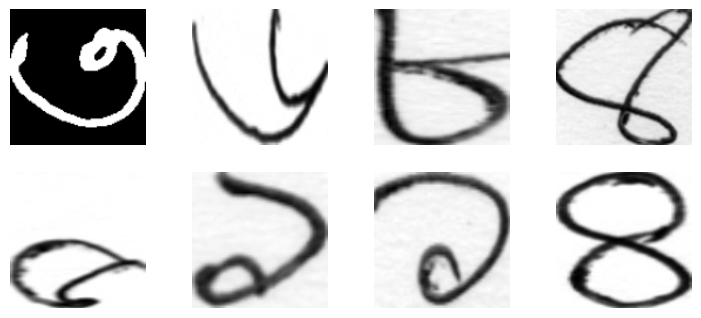

In [5]:
#This will create a grid of 8 random images from the input variable, with columns = 4 and figure size = (9, 6)

display_image(image_count = 8, images = input, index = index, columns =4, fig_size = (9, 6))

#### Input Labels

In [6]:
#Acquire the first 40000 labels, and categorically reshape the array to form (40000,10) shape

labels = pd.read_csv("Bangla_MNIST/labels.csv")
labels = labels["digit"]
labels = tf.keras.utils.to_categorical(labels[:index+20])

print('Labels shape: {}\nLabels dtype: {}\nNumber of classes: {}\nNumber of data: {}'.format(
    labels.shape, labels.dtype, labels.shape[1], labels.shape[0]))

Labels shape: (40020, 10)
Labels dtype: float32
Number of classes: 10
Number of data: 40020


##

# Dataset Preprocessing

In [7]:
#Divide the inputs in train and test datasets, followed by batching.

x_train, x_test, y_train, y_test = train_test_split(input[:index], labels[:index], test_size=0.2, random_state=48)

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset = test_dataset.batch(batch_size)
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)

print("Shape of x_train:", x_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of x_test:", x_test.shape)
print("Shape of y_test:", y_test.shape)

Shape of x_train: (32000, 128, 128)
Shape of y_train: (32000, 10)
Shape of x_test: (8000, 128, 128)
Shape of y_test: (8000, 10)


##

# Model Implementation

In [34]:
#Create model using fully connected dense layers in the Multi-Layer Perceptron architecture

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape = (128, 128)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(10, activation='sigmoid')
])

model.compile(optimizer='SGD', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_13 (Flatten)        (None, 16384)             0         
                                                                 
 dense_54 (Dense)            (None, 128)               2097280   
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_55 (Dense)            (None, 256)               33024     
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_56 (Dense)            (None, 128)               32896     
                                                                 
 dropout_3 (Dropout)         (None, 128)             

In [35]:
#Model training and evaluation

history = model.fit(train_dataset,
                    batch_size=batch_size,
                    epochs=10,
                    validation_data=test_dataset)

Epoch 1/10
500/500 [==============================] - 5s 8ms/step - loss: 2.3083 - accuracy: 0.0980 - val_loss: 2.3033 - val_accuracy: 0.1006
Epoch 2/10
500/500 [==============================] - 3s 6ms/step - loss: 2.3009 - accuracy: 0.1036 - val_loss: 2.3036 - val_accuracy: 0.0996
Epoch 3/10
500/500 [==============================] - 3s 6ms/step - loss: 2.2984 - accuracy: 0.1099 - val_loss: 2.3031 - val_accuracy: 0.1023
Epoch 4/10
500/500 [==============================] - 4s 7ms/step - loss: 2.2969 - accuracy: 0.1128 - val_loss: 2.3038 - val_accuracy: 0.1000
Epoch 5/10
500/500 [==============================] - 3s 6ms/step - loss: 2.2935 - accuracy: 0.1179 - val_loss: 2.3044 - val_accuracy: 0.1004
Epoch 6/10
500/500 [==============================] - 3s 6ms/step - loss: 2.2909 - accuracy: 0.1207 - val_loss: 2.3058 - val_accuracy: 0.1026
Epoch 7/10
500/500 [==============================] - 3s 6ms/step - loss: 2.2876 - accuracy: 0.1247 - val_loss: 2.3052 - val_accuracy: 0.0996
Epoch 